In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from curl_cffi import requests
import numpy as np
session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('...', session=session)

In [24]:
# List of tickers (use correct format for BRK.B)
tickers = [
    "AAPL", "MSFT", "GOOG", "GOOGL", "AMZN", "NVDA", "META", "BRK-B", "TSLA", "LLY",
    "UNH", "V", "XOM", "JPM", "JNJ", "MA", "AVGO", "PG", "CVX", "HD", "ORCL", "MRK",
    "ABBV", "ADBE", "COST", "KO", "PEP", "CSCO", "BAC", "ACN"
]

# Start and end dates
start_date = "2014-04-30"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

# Dictionary to hold results
market_cap_df = pd.DataFrame()
stock_prices_df = pd.DataFrame()

for ticker in tickers:
    try:
        t = yf.Ticker(ticker)
        info = t.info
        shares_out = info.get("sharesOutstanding", None)

        if shares_out is None:
            print(f"No shares outstanding for {ticker}")
            continue

        # Get monthly adjusted close prices
        hist = t.history(start=start_date, end=end_date, interval="1mo")
        hist = hist[["Close"]].rename(columns={"Close": ticker})

        stock_prices_df = pd.concat([stock_prices_df, hist[ticker]], axis=1)
        
        hist[ticker] = hist[ticker] * shares_out  # approximate market cap

        market_cap_df = pd.concat([market_cap_df, hist[ticker]], axis=1)

    except Exception as e:
        print(f"Error retrieving {ticker}: {e}")

# Optional: convert to billions
# market_cap_df = market_cap_df / 1e9
# market_cap_df.index = market_cap_df.index.date  # simplify index
# market_cap_df.columns.name = "Ticker"
print(market_cap_df.index)
market_cap_df.index = pd.to_datetime(market_cap_df.index)
market_cap_df.index = market_cap_df.index.to_period('M')

stock_prices_df.index = pd.to_datetime(stock_prices_df.index)
stock_prices_df.index = stock_prices_df.index.to_period('M')


# Save to CSV
market_cap_df.to_csv("approx_historical_market_caps.csv")

# Display result
print(market_cap_df.head())

Index([2014-05-01 00:00:00-04:00, 2014-06-01 00:00:00-04:00,
       2014-07-01 00:00:00-04:00, 2014-08-01 00:00:00-04:00,
       2014-09-01 00:00:00-04:00, 2014-10-01 00:00:00-04:00,
       2014-11-01 00:00:00-04:00, 2014-12-01 00:00:00-05:00,
       2015-01-01 00:00:00-05:00, 2015-02-01 00:00:00-05:00,
       ...
       2024-09-01 00:00:00-04:00, 2024-10-01 00:00:00-04:00,
       2024-11-01 00:00:00-04:00, 2024-12-01 00:00:00-05:00,
       2025-01-01 00:00:00-05:00, 2025-02-01 00:00:00-05:00,
       2025-03-01 00:00:00-05:00, 2025-04-01 00:00:00-04:00,
       2025-05-01 00:00:00-04:00, 2025-06-01 00:00:00-04:00],
      dtype='object', length=134)
                 AAPL          MSFT          GOOG         GOOGL          AMZN  \
2014-05  2.956270e+11  2.552518e+11  1.515030e+11  1.653585e+11  1.659078e+11   
2014-06  3.055014e+11  2.618243e+11  1.556674e+11  1.691247e+11  1.723997e+11   
2014-07  3.142790e+11  2.709915e+11  1.546716e+11  1.676436e+11  1.661413e+11   
2014-08  3.369622e+1

C:\Users\juanp\AppData\Local\Temp\ipykernel_12204\1453649578.py:45: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  market_cap_df.index = market_cap_df.index.to_period('M')
C:\Users\juanp\AppData\Local\Temp\ipykernel_12204\1453649578.py:48: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  stock_prices_df.index = stock_prices_df.index.to_period('M')


In [26]:
stock_prices_df.to_csv("stock_prices.csv")

# 📊 Uso de Proxies (ETFs) para Factores del Mercado

## ¿Por qué utilizamos proxies para factores?

En el análisis de factores, especialmente cuando no se dispone de modelos propietarios como Bloomberg PORT o AQR, usamos **ETFs como proxies** para representar distintos factores del mercado financiero. Esto se debe a que:

- ✅ Son **instrumentos reales e invertibles**, usados por inversores institucionales y minoristas.
- ✅ Proveen **acceso público a datos históricos** de precios y rendimientos.
- ✅ Representan portafolios que replican **de forma razonable la exposición a un factor** específico.
- ✅ Son útiles tanto para **análisis cuantitativo** como para estrategias de inversión prácticas.

---

## 🎯 ETFs seleccionados como proxies de factores

A continuación, se describen los ETFs utilizados como proxies para los factores del mercado estadounidense:

| Factor       | ETF (Ticker) | Nombre                            | Descripción |
|--------------|--------------|-----------------------------------|-------------|
| **Market**   | `SPY`        | SPDR S&P 500 ETF Trust            | Replica el índice S&P 500. Representa el mercado estadounidense de gran capitalización. Altamente líquido y comúnmente usado como benchmark. |
| **Value**    | `VLUE`       | iShares MSCI USA Value Factor ETF | Invierte en acciones con múltiplos bajos (P/E, P/B). Representa el factor de **valor**. Construcción robusta basada en fundamentos. |
| **Size**     | `IWM`        | iShares Russell 2000 ETF          | Replica el índice Russell 2000, enfocado en **small caps**. Representa el factor de **tamaño** (size premium). |
| **Volatility** | `USMV`     | iShares MSCI USA Minimum Volatility ETF | Portafolio optimizado para minimizar la volatilidad total. Captura el factor de **baja volatilidad**. |
| **Growth**   | `IWF`        | iShares Russell 1000 Growth ETF   | ETF enfocado en compañías de gran capitalización con alta tasa de crecimiento esperado. Representa el factor de **crecimiento**. |
| **Momentum** | `MTUM`       | iShares MSCI USA Momentum Factor ETF | Selecciona acciones con mejor desempeño en los últimos 6–12 meses. Captura el factor de **momentum**. |

---

## 🧠 Nota importante

Estos ETFs **no replican factores puros**, como lo harían los modelos de Fama-French o los portafolios de Bloomberg/AQR. Sin embargo, son suficientemente precisos para:
- Evaluar rendimiento histórico de factores
- Construir carteras multifactoriales simples
- Realizar backtests sin acceso institucional




In [70]:
# Mapeo de factores a ETFs proxy
etf_map = {
    'MARKET': 'SPY',      # SPDR S&P 500 ETF Trust
    'VALUE': 'VLUE',      # iShares MSCI USA Value Factor ETF
    'SIZE': 'IWM',        # iShares Russell 2000 ETF (Small Cap)
    'VOLATILITY': 'USMV', # iShares MSCI USA Min Volatility
    'GROWTH': 'IWF',      # iShares Russell 1000 Growth ETF
    'MOMENTUM': 'MTUM'    # iShares MSCI USA Momentum Factor ETF
}



factors = yf.download(
    tickers=list(etf_map.values()),
    start=start_date,
    end=end_date,
    interval='1mo',
    progress=False
)['Close']

# Renombrar columnas para usar los nombres de factor
factors.columns = etf_map.keys()


# Ajustar formato de fecha para que sea dd/mm/yyyy
factors.index = factors.index.to_period('M')
# Guardar a CSV con formato pedido
factors.to_csv("factor_monthly_prices.csv")

In [71]:
factors

,MARKET,VALUE,SIZE,VOLATILITY,GROWTH,MOMENTUM
Date,,,,,,
2014-05,79.963326,97.582253,54.544823,159.000793,30.044113,47.210361
2014-06,81.486794,102.726791,55.501122,161.509476,30.263662,48.215809
2014-07,79.963326,96.138321,55.094112,160.102661,29.984806,48.056316
2014-08,83.876778,101.168297,57.628788,166.420898,31.177986,49.449245
2014-09,82.419601,94.910393,57.091919,163.361267,30.793886,48.553802
...,...,...,...,...,...,...
2025-02,394.178070,214.169388,218.429993,592.397949,94.240402,110.463455
2025-03,360.703888,199.043350,202.130005,557.712280,93.333572,105.981712
2025-04,366.790009,194.860001,209.630005,554.539978,92.540001,102.559998


In [17]:
# Guardar a CSV con formato pedido
factors.to_csv("factor_monthly_prices.csv")

## Benchmark

## 🧭 ¿Por qué usamos VTI como benchmark?

1. **Cobertura amplia del mercado**: VTI representa el mercado accionario total de EE. UU., incluyendo grandes, medianas y pequeñas empresas.

2. **Neutralidad**: No tiene sesgo hacia ningún factor (como value, growth o momentum), lo que lo hace ideal como punto de referencia general.

3. **Accesibilidad y datos históricos**: Es un ETF líquido, fácil de replicar y con historial suficiente para análisis de largo plazo.


In [10]:
vti = yf.download("VTI", start=start_date, interval="1mo")

# Extraer solo el precio ajustado de cierre
vti_prices = vti[['Close']].copy()
vti_prices.columns = ['VTI_Price']
vti_prices.index = vti_prices.index.to_period('M')  # Opcional: índice como Year-Month

# Mostrar las primeras filas
print(vti_prices.head())

# Guardar como CSV si deseas
vti_prices.to_csv("vti_monthly_prices.csv")

[*********************100%***********************]  1 of 1 completed

         VTI_Price
Date              
2014-05  82.380882
2014-06  84.192642
2014-07  82.853935
2014-08  86.293053
2014-09  84.099998


# ETF

In [13]:
# Lista de tickers
tickers = ["SMH", "SPY", "CIBR", "QQQ", "AIQ"]

# Descargar datos mensuales desde abril 2014 (si existen)
data = yf.download(tickers, start=start_date, interval="1mo")['Close']

# Renombrar columnas para mayor claridad
data.columns = [f"{ticker}_Price" for ticker in data.columns]
data.index = data.index.to_period('M')  # Opcional: índice mensual

# Mostrar primeros registros
print(data.head())

# Guardar como CSV
data.to_csv("monthly_etf_prices.csv")

[*********************100%***********************]  5 of 5 completed

         AIQ_Price  CIBR_Price  QQQ_Price  SMH_Price   SPY_Price
Date                                                            
2014-05        NaN         NaN  83.638908  20.485874  159.000824
2014-06        NaN         NaN  86.020470  21.878418  161.509430
2014-07        NaN         NaN  87.271118  21.555700  160.102676
2014-08        NaN         NaN  91.642937  22.846569  166.420929
2014-09        NaN         NaN  90.733665  22.585745  163.361237


# Data Preparation

In [58]:
tickers = market_cap_df.columns

company_names = [
    "Apple Inc", "Microsoft Corp", "Alphabet Inc Class C", "Alphabet Inc Class A",
    "Amazon.com Inc", "NVIDIA Corp", "Meta Platforms Inc", "Berkshire Hathaway Inc",
    "Tesla Inc", "Eli Lilly and Co", "UnitedHealth Group", "Visa Inc",
    "Exxon Mobil Corp", "JPMorgan Chase", "Johnson & Johnson", "Mastercard Inc",
    "Broadcom Inc", "Procter & Gamble", "Chevron Corp", "Home Depot Inc",
    "Oracle Corp", "Merck & Co", "AbbVie Inc", "Adobe Inc",
    "Costco Wholesale", "Coca-Cola Co", "PepsiCo Inc", "Cisco Systems",
    "Bank of America", "Accenture Plc"
]

sectors = [
    "Information Technology",  # AAPL
    "Information Technology",  # MSFT
    "Communication Services",  # GOOG
    "Communication Services",  # GOOGL
    "Consumer Discretionary",  # AMZN
    "Information Technology",  # NVDA
    "Communication Services",  # META
    "Financials",              # BRK-B
    "Consumer Discretionary",  # TSLA
    "Health Care",             # LLY
    "Health Care",             # UNH
    "Information Technology",  # V
    "Energy",                  # XOM
    "Financials",              # JPM
    "Health Care",             # JNJ
    "Information Technology",  # MA
    "Information Technology",  # AVGO
    "Consumer Staples",        # PG
    "Energy",                  # CVX
    "Consumer Discretionary",  # HD
    "Information Technology",  # ORCL
    "Health Care",             # MRK
    "Health Care",             # ABBV
    "Information Technology",  # ADBE
    "Consumer Staples",        # COST
    "Consumer Staples",        # KO
    "Consumer Staples",        # PEP
    "Information Technology",  # CSCO
    "Financials",              # BAC
    "Information Technology",  # ACN
]

last_stock_price = stock_prices_df.tail(1).values
last_market_capitalization = market_cap_df.tail(1).values

total_market_cap = np.sum(last_market_capitalization)
weights = (last_market_capitalization / total_market_cap)

In [59]:
weights

array([[0.11183005, 0.13454647, 0.03659381, 0.03874533, 0.08582148,
        0.13196042, 0.05650748, 0.02495241, 0.03993565, 0.02803506,
        0.01084005, 0.02300995, 0.01841629, 0.02806368, 0.01440663,
        0.01930586, 0.0445833 , 0.01432237, 0.00963316, 0.01344875,
        0.02300246, 0.00781997, 0.01286419, 0.00636243, 0.01673695,
        0.01165086, 0.00683777, 0.00967305, 0.01265673, 0.0074374 ]])

In [60]:
weights_df = pd.DataFrame({
    "Ticker": tickers,
    "Name": company_names,
    "Price": last_stock_price[0],
    "GICS Sector": sectors,
    "Market Cap": last_market_capitalization[0],
    "Weight": weights[0]
})
weights_df.set_index("Ticker", inplace=True)

In [61]:
weights_df.to_csv('weights.csv')

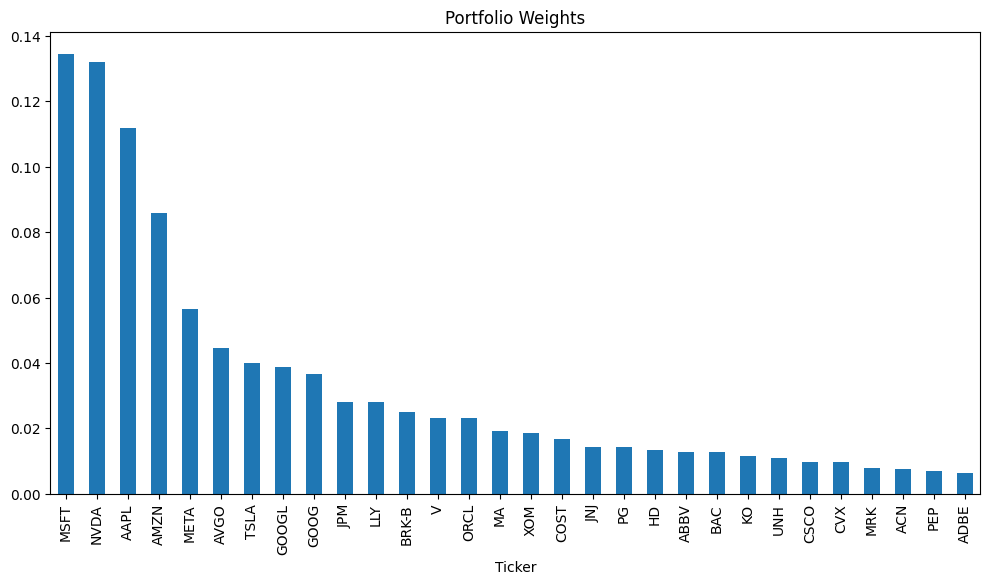

In [66]:
weights_df['Weight'].sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Portfolio Weights')
plt.show()

## Monthly returns

In [107]:

stock_returns_df = np.log(stock_prices_df / stock_prices_df.shift(1)).dropna()
stock_returns_df.to_csv('data/processed_data/stock_returns.csv')

factor_returns_df = np.log(factors / factors.shift(1)).dropna()
factor_returns_df.to_csv('data/processed_data/factor_returns.csv')

vti_returns_df = np.log(vti_prices / vti_prices.shift(1)).dropna()
vti_returns_df.columns = ['VTI']
vti_returns_df.to_csv('data/processed_data/vti_returns.csv')



In [106]:
stock_returns_df

,AAPL,MSFT,GOOG,GOOGL,AMZN,NVDA,META,BRK-B,TSLA,LLY,...,ORCL,MRK,ABBV,ADBE,COST,KO,PEP,CSCO,BAC,ACN
2014-06,0.032856,0.025423,0.027117,0.022521,0.038384,-0.019913,0.061126,-0.013966,0.144457,0.046145,...,-0.036103,-0.000173,0.038102,0.114368,-0.004383,0.034830,0.011369,0.009299,0.015078,-0.007517
2014-07,0.028326,0.034414,-0.006418,-0.008796,-0.036977,-0.057730,0.076642,-0.008969,-0.072373,-0.018015,...,-0.003460,-0.011864,-0.075417,-0.043931,0.020456,-0.067742,-0.006524,0.015176,-0.007195,-0.019486
2014-08,0.069690,0.051258,0.000000,0.004837,0.079947,0.105646,0.029432,0.090056,0.188794,0.040127,...,0.030741,0.057696,0.062206,0.037553,0.032700,0.060011,0.048628,-0.001953,0.053618,0.022204
2014-09,-0.012259,0.026491,0.010026,0.010335,-0.050201,-0.048369,0.054869,0.006464,-0.105566,0.028109,...,-0.081489,-0.013904,0.043885,-0.038420,0.034419,0.022281,0.006466,0.007177,0.057952,0.003202
2014-10,0.069489,0.012646,-0.032173,-0.035531,-0.054098,0.057399,-0.052599,0.014517,-0.004046,0.022565,...,0.019915,-0.015597,0.094114,0.013352,0.062257,-0.011194,0.039659,-0.020613,0.009509,-0.002462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02,0.024444,-0.044512,-0.177160,-0.180774,-0.113019,0.039599,-0.030915,0.091994,-0.322795,0.126691,...,-0.021347,-0.068798,0.137472,0.002534,0.067791,0.114908,0.018280,0.063097,-0.004329,-0.095234
2025-03,-0.083915,-0.053942,-0.097443,-0.096344,-0.109515,-0.142030,-0.147855,0.035841,-0.122659,-0.106850,...,-0.172065,-0.027363,0.002341,-0.134079,-0.102106,0.005741,-0.023270,-0.038154,-0.099593,-0.110507
2025-04,-0.044321,0.051578,0.030530,0.027697,-0.031176,0.005062,-0.047745,0.001257,0.085029,0.084742,...,0.006488,-0.043536,-0.071307,-0.022545,0.050230,0.020254,-0.091871,-0.066669,-0.039054,-0.042186
2025-05,-0.056384,0.152465,0.071703,0.078336,0.105843,0.215624,0.165005,-0.056493,0.205293,-0.197731,...,0.165966,-0.103276,-0.037975,0.101623,0.044909,-0.006222,-0.030935,0.094647,0.101265,0.062335


## Risk Free Rate

Source: https://home.treasury.gov

The 10-year yield is used as a proxy for the risk-free rate 
 in financial models due to its stability and the backing of the U.S. government.

This rate is generally reflective of broader economic conditions and investor confidence.



This class provides functionalities for fetching, plotting, and interpolating the U.S. Treasury yield curve data. 
The yield curve represents the relationship between interest rates and the time to maturity of a debt for a borrower in a given currency.
The curve is a critical indicator in financial markets, often used as a benchmark for other interest rates, and provides insights into future economic conditions.

    - https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value

In [77]:
from pyriskmgmt.fixed_income_models import YieldCurve 
# calling the class YieldCurve from the pyriskmgmt.fixed_income_models module
model = YieldCurve(years_back=1)

#retrieving the 10-year annualized today's interest rate, the obtaining the monthly interest rate
rf = model.yield_curve_df.iloc[-1][120] / 100 / 12

# showing the rounded monthly rf
round(rf,4) 

Fetching Process --->  Done                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

0.0037

In [82]:
import json
import os

# Guardar en JSON
with open('data/variables.json', 'w') as f:
    json.dump({'rf': rf}, f)

# SHARPE and SORTINO Ratio of the Russell 50 Index

## Sharpe Ratio

The **Sharpe Ratio** is a measure of the risk-adjusted return of an investment or portfolio. It indicates how much excess return an investment provides for each unit of risk taken. The formula for the Sharpe Ratio is:

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

Where:
- $R_p$ = Return of the portfolio  
- $R_f$ = Risk-free rate  
- $\sigma_p$ = Standard deviation of the portfolio returns (total risk)  

---

## Sortino Ratio

The **Sortino Ratio** is a variation of the Sharpe Ratio that focuses on downside risk, particularly the standard deviation of negative returns. It measures the return per unit of downside risk. The formula for the Sortino Ratio is:

$$
\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_d}
$$

Where:
- $R_p$ = Return of the portfolio  
- $R_f$ = Risk-free rate  
- $\sigma_d$ = Standard deviation of the negative returns (downside risk) 



In [102]:
expected_return = vti_returns_df['VTI'].mean()
std = vti_returns_df['VTI'].std()
sharpe_ratio = (expected_return - rf) / std

# Sortino Ratio
downside_vti_returns = vti_returns_df[vti_returns_df['VTI']<0]
std_downside = downside_vti_returns['VTI'].std()
sortino_ratio = (expected_return - rf) / std_downside

print("VTI Index")
print("-"*30)
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Sortino Ratio: {sortino_ratio}")




VTI Index
------------------------------
Sharpe Ratio: 0.13014273662957962
Sortino Ratio: 0.17567319716812427


In [105]:
with open('data/variables.json', 'w') as f:
    json.dump({'RiskFree': rf,
               'SharpeRatio': round(sharpe_ratio,4),
               'SortinoRatio': round(sortino_ratio,4),
               'VTI_ExpectedReturn': round(expected_return,4),
               'VTI_Std': round(std,4)
               }, f)


## Backtesting data

### Market Capitalization

In [108]:
mktCap = pd.read_csv("data/raw_data/approx_historical_market_caps.csv", index_col='Unnamed: 0')

In [109]:
mktCap

,AAPL,MSFT,GOOG,GOOGL,AMZN,NVDA,META,BRK-B,TSLA,LLY,...,ORCL,MRK,ABBV,ADBE,COST,KO,PEP,CSCO,BAC,ACN
2014-05,2.956270e+11,2.552518e+11,1.515030e+11,1.653585e+11,1.659078e+11,1.097333e+10,1.367891e+11,1.723401e+11,4.461459e+10,4.321873e+10,...,9.968612e+10,9.908375e+10,6.135469e+10,2.750695e+10,4.122676e+10,1.235857e+11,8.691101e+10,6.927338e+10,9.085564e+10,4.225697e+10
2014-06,3.055014e+11,2.618243e+11,1.556674e+11,1.691247e+11,1.723997e+11,1.075697e+10,1.454114e+11,1.699498e+11,5.154824e+10,4.525977e+10,...,9.615130e+10,9.906662e+10,6.373751e+10,3.083983e+10,4.104647e+10,1.279661e+11,8.790478e+10,6.992053e+10,9.223591e+10,4.194050e+10
2014-07,3.142790e+11,2.709915e+11,1.546716e+11,1.676436e+11,1.661413e+11,1.015356e+10,1.569942e+11,1.684324e+11,4.794936e+10,4.445170e+10,...,9.581921e+10,9.789824e+10,5.910741e+10,2.951435e+10,4.189477e+10,1.195845e+11,8.733314e+10,7.098973e+10,9.157466e+10,4.113115e+10
2014-08,3.369622e+11,2.852441e+11,1.546716e+11,1.684565e+11,1.799692e+11,1.128496e+10,1.616834e+11,1.843048e+11,5.791286e+10,4.627169e+10,...,9.881051e+10,1.037127e+11,6.290105e+10,3.064378e+10,4.328736e+10,1.269805e+11,9.168491e+10,7.085120e+10,9.661876e+10,4.205463e+10
2014-09,3.328566e+11,2.929014e+11,1.562303e+11,1.702065e+11,1.711576e+11,1.075211e+10,1.708027e+11,1.854999e+11,5.211084e+10,4.759080e+10,...,9.107791e+10,1.022807e+11,6.572294e+10,2.948878e+10,4.480321e+10,1.298416e+11,9.227967e+10,7.136157e+10,1.023835e+11,4.218952e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02,3.603381e+12,2.939343e+12,9.379517e+11,9.886926e+11,2.253649e+12,3.046007e+12,1.449473e+12,6.899915e+11,9.436769e+11,8.233730e+11,...,4.640036e+11,2.296585e+11,3.658496e+11,1.869143e+11,4.639167e+11,3.021137e+11,2.063118e+11,2.521919e+11,3.430208e+11,2.170935e+11
2025-03,3.313344e+12,2.784989e+12,8.508663e+11,8.978825e+11,2.019876e+12,2.642702e+12,1.250252e+12,7.151698e+11,8.347440e+11,7.399324e+11,...,3.906561e+11,2.234596e+11,3.667072e+11,1.634605e+11,4.188859e+11,3.038532e+11,2.015663e+11,2.427509e+11,3.105045e+11,1.943813e+11
2025-04,3.169701e+12,2.932402e+12,8.772440e+11,9.230985e+11,1.957876e+12,2.656113e+12,1.191961e+12,7.160695e+11,9.088261e+11,8.053690e+11,...,3.931988e+11,2.139397e+11,3.414690e+11,1.598165e+11,4.404640e+11,3.100702e+11,1.838735e+11,2.270946e+11,2.986117e+11,1.863516e+11
2025-05,2.995927e+12,3.415374e+12,9.424553e+11,9.983183e+11,2.176468e+12,3.295268e+12,1.405798e+12,6.767377e+11,1.115934e+12,6.608782e+11,...,4.641842e+11,1.929475e+11,3.287447e+11,1.769114e+11,4.606957e+11,3.081469e+11,1.782724e+11,2.496384e+11,3.304346e+11,1.983376e+11


In [116]:
total_mktCap = mktCap.sum(axis=1)
rel_mktCap = mktCap.div(total_mktCap, axis=0)
rel_mktCap

,AAPL,MSFT,GOOG,GOOGL,AMZN,NVDA,META,BRK-B,TSLA,LLY,...,ORCL,MRK,ABBV,ADBE,COST,KO,PEP,CSCO,BAC,ACN
2014-05,0.089217,0.077032,0.045722,0.049903,0.050069,0.003312,0.041281,0.052010,0.013464,0.013043,...,0.030084,0.029902,0.018516,0.008301,0.012442,0.037297,0.026229,0.020906,0.027419,0.012753
2014-06,0.090218,0.077319,0.045970,0.049944,0.050911,0.003177,0.042942,0.050188,0.015223,0.013366,...,0.028394,0.029255,0.018822,0.009107,0.012121,0.037790,0.025959,0.020648,0.027238,0.012385
2014-07,0.093307,0.080456,0.045921,0.049772,0.049326,0.003015,0.046611,0.050006,0.014236,0.013197,...,0.028448,0.029065,0.017549,0.008763,0.012438,0.035504,0.025929,0.021076,0.027188,0.012212
2014-08,0.095447,0.080798,0.043812,0.047717,0.050978,0.003197,0.045798,0.052206,0.016404,0.013107,...,0.027989,0.029377,0.017817,0.008680,0.012262,0.035968,0.025971,0.020069,0.027368,0.011912
2014-09,0.094484,0.083142,0.044347,0.048315,0.048584,0.003052,0.048484,0.052656,0.014792,0.013509,...,0.025853,0.029033,0.018656,0.008371,0.012718,0.036857,0.026194,0.020257,0.029062,0.011976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02,0.139321,0.113647,0.036265,0.038227,0.087135,0.117771,0.056042,0.026678,0.036486,0.031835,...,0.017940,0.008880,0.014145,0.007227,0.017937,0.011681,0.007977,0.009751,0.013263,0.008394
2025-03,0.138979,0.116817,0.035690,0.037662,0.084724,0.110849,0.052442,0.029998,0.035014,0.031037,...,0.016386,0.009373,0.015382,0.006856,0.017570,0.012745,0.008455,0.010182,0.013024,0.008153
2025-04,0.133612,0.123610,0.036978,0.038911,0.082530,0.111963,0.050245,0.030184,0.038310,0.033949,...,0.016575,0.009018,0.014394,0.006737,0.018567,0.013070,0.007751,0.009573,0.012587,0.007855
2025-05,0.116697,0.133035,0.036710,0.038886,0.084777,0.128357,0.054758,0.026360,0.043468,0.025742,...,0.018081,0.007516,0.012805,0.006891,0.017945,0.012003,0.006944,0.009724,0.012871,0.007726


In [119]:
print(rel_mktCap.sum(axis=1))
rel_mktCap.to_csv("data/processed_data/relative_market_caps.csv")

2014-05    1.0
2014-06    1.0
2014-07    1.0
2014-08    1.0
2014-09    1.0
          ... 
2025-02    1.0
2025-03    1.0
2025-04    1.0
2025-05    1.0
2025-06    1.0
Length: 134, dtype: float64


### Risk Free Rate

In [17]:
from pyriskmgmt.fixed_income_models import YieldCurve 
# calling the class YieldCurve from the pyriskmgmt.fixed_income_models module
model = YieldCurve(years_back=12)


Fetching Process --->  Done                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [26]:
modelo_curva = model.yield_curve_df
modelo_curva

,3,6,12,24,36,60,84,120,240,360
Date,,,,,,,,,,
2014-01-02,0.07,0.09,0.13,0.39,0.76,1.72,2.41,3.00,3.68,3.92
2014-01-03,0.07,0.10,0.13,0.41,0.80,1.73,2.42,3.01,3.69,3.93
2014-01-06,0.05,0.08,0.12,0.40,0.78,1.70,2.38,2.98,3.66,3.90
2014-01-07,0.04,0.08,0.13,0.40,0.80,1.69,2.37,2.96,3.64,3.88
2014-01-08,0.05,0.08,0.13,0.43,0.87,1.77,2.44,3.01,3.67,3.90
...,...,...,...,...,...,...,...,...,...,...
2025-06-12,4.46,4.29,4.06,3.90,3.85,3.97,4.15,4.36,4.86,4.84
2025-06-13,4.45,4.30,4.09,3.96,3.90,4.02,4.20,4.41,4.93,4.90
2025-06-16,4.43,4.32,4.10,3.97,3.93,4.04,4.23,4.46,4.97,4.96


In [28]:
curva_df = modelo_curva
curva_df.index = pd.to_datetime(curva_df.index, format='%m/%d/%Y')
curva_mes = curva_df.resample('M').last()
curva_mes
#yield_curve_mes

,3,6,12,24,36,60,84,120,240,360
Date,,,,,,,,,,
2014-01-31,0.02,0.06,0.10,0.34,0.69,1.49,2.13,2.67,3.35,3.61
2014-02-28,0.05,0.08,0.12,0.33,0.69,1.51,2.13,2.66,3.31,3.59
2014-03-31,0.05,0.07,0.13,0.44,0.90,1.73,2.30,2.73,3.31,3.56
2014-04-30,0.03,0.05,0.11,0.42,0.87,1.69,2.25,2.67,3.22,3.47
2014-05-31,0.04,0.06,0.10,0.37,0.79,1.54,2.06,2.48,3.05,3.33
...,...,...,...,...,...,...,...,...,...,...
2025-02-28,4.32,4.25,4.08,3.99,3.99,4.03,4.14,4.24,4.55,4.51
2025-03-31,4.32,4.23,4.03,3.89,3.89,3.96,4.09,4.23,4.62,4.59
2025-04-30,4.31,4.19,3.85,3.60,3.58,3.72,3.93,4.17,4.68,4.66


In [30]:
curva_mes.to_csv("data/processed_data/monthly_yield_curve.csv")